In [223]:
# importations
import numpy as np
import pandas as pd
from pyedflib import EdfReader
import mne
import EntropyHub

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.interpolate import PchipInterpolator,interp1d

%matplotlib inline

import seaborn as sns

import copy
import os
import importlib

import generisAPI
importlib.reload(generisAPI)

import generisAPI.file_operators as fp
importlib.reload(generisAPI.file_operators)

import generisAPI.data_cleaning as dcln
importlib.reload(generisAPI.data_cleaning)

import generisAPI.preprocessing as ppcn
importlib.reload(generisAPI.preprocessing)

import generisAPI.processing as pcn
importlib.reload(generisAPI.processing)

import generisAPI.audProcessing as audpcn
importlib.reload(generisAPI.audProcessing)

import generisAPI.plots as plots
importlib.reload(generisAPI.plots)

import generisAPI.fuzzEntropy as fuzzEnt
importlib.reload(generisAPI.fuzzEntropy)

<module 'generisAPI.fuzzEntropy' from '/media/emmanuel/DATA/Emmanuel_petron_Olateju/github/ubuntu/MMN_SZ/notebooks/generisAPI/fuzzEntropy.py'>

### Import, compile data and preprocess

In [2]:
# definitions
electrodes=[
    'Fp1','Fp2','F3','F4','C3',
    'C4','P3','P4','O1','O2',
    'F7','F8','T3','T4','T5',
    'T6','Fz','Pz','Cz'
    ]
len(electrodes)

19

In [3]:
# compile eeg_data and annotations
subjects_dataset_root_path = '../acquired_dataset/'

data = fp.xtract_id_subject_info_dict(subjects_dataset_root_path)
print(len(data))

32


### Preprocessing

In [32]:
# assert eeg_data trials match marker trials

trialMarkerLength = dcln.assertTrialsMarkersLength()
trialMarkerLength.fit(data)
print(trialMarkerLength.indices)
clean_data = trialMarkerLength.transform(data,False)

[]


In [33]:
# check for null eeg_data

null_data_checker = dcln.nullIndicesTracer()
null_data_checker.fit(clean_data)
null_data_checker.indices['1']={}
null_data_checker.indices['2']={}
print(null_data_checker.indices)
clean_data = null_data_checker.transform(clean_data,True)


{'16': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '20': {'rest1': [], 'arith': [], 'rest2': [], 'auditory': [0]}, '23': {'rest1': [], 'arith': [0], 'rest2': [0], 'auditory': [0]}, '32': {'rest1': [0, 1, 2], 'arith': [0, 1, 2], 'rest2': [0, 1, 2], 'auditory': [0, 1, 2]}, '4': {'rest1': [], 'arith': [], 'rest2': [2], 'auditory': [2]}, '5': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '6': {'rest1': [], 'arith': [], 'rest2': [], 'auditory': [0]}, '8': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '9': {'rest1': [0, 1], 'arith': [0, 1], 'rest2': [0, 1], 'auditory': [0, 1]}, '1': {}, '2': {}}


In [34]:
#prerprocessing
preprocess_method=[
    [ppcn.channel_dropper,{'index':[19,20,21,22,23],'axis':0}],
    [ppcn.filter,{'lfreq':75,'hfreq':45,'sfreq':200}],
    [ppcn.filter,{'lfreq':100,'hfreq':None,'sfreq':200}],
    # [ppcn.resampler,{'up':1,'down':1}],
    [ppcn.baseline_corrector,{'with_std':False}]
]

preprocess_pipeline = ppcn.ppcn_pipeline(preprocess_method)

mne.set_log_level('ERROR')
clean_data = ppcn.all_subjects_preprocessor(
    preprocess_pipeline,
    clean_data
)

In [35]:
auditory_data = pcn.xtract_phase_data('auditory',clean_data)
arithmetic_data = pcn.xtract_phase_data('arith',clean_data)
firstRest_data = pcn.xtract_phase_data('rest1',clean_data)
secondRest_data = pcn.xtract_phase_data('rest2',clean_data)

### Auditory stimuli processing

In [8]:
aud_data = audpcn.all_subjects_phase_auditory_epochs(auditory_data,0.45)

In [9]:
aud_method=[
    [audpcn.epoch_std,{}],
    [audpcn.aud_stimuli_trial_average,{}],
    # [ppcn.electrode_grouper,{'electrodes':electrodes,'target':'T'}]
]
aud_pcn_pipeline = audpcn.pipeline(aud_method)
avg_aud = audpcn.all_subjects_processor(aud_pcn_pipeline,aud_data)

mmn_pcn = audpcn.stimuli_mmn(' ',5)
mmn_eeg = mmn_pcn.fit_transform(avg_aud)

aud_method=[
    [audpcn.epoch_MinMax,{'range':(-1,1),'axis':1}],
]
aud_pcn_pipeline = audpcn.pipeline(aud_method)
mmn_eeg = audpcn.all_subjects_processor(aud_pcn_pipeline,mmn_eeg)


### STFT Feature

In [10]:
stft_feature_method=[
    [pcn.trial_epoching,{'dummy':0}],
    [pcn.stft,{'fs':9,'sfreq':200}],
    [pcn.trial_averaging,{'axis':0,'dummy':0}],
    [ppcn.electrode_grouper,{'electrodes':electrodes,'target':'F'}],
    [pcn.trial_averaging,{'axis':0,'dummy':0}],
]

stft_feature_pipeline=ppcn.ppcn_pipeline(stft_feature_method)

firstRest_stft = pcn.all_subjects(stft_feature_pipeline,firstRest_data)
arithmetic_stft = pcn.all_subjects(stft_feature_pipeline,arithmetic_data)
secondRest_stft = pcn.all_subjects(stft_feature_pipeline,secondRest_data)
auditory_stft = pcn.all_subjects(stft_feature_pipeline,auditory_data)

/media/emmanuel/DATA/Emmanuel_petron_Olateju/github/MMN_SZ/notebooks/generisAPI/processing.py:52: ComplexWarning: Casting complex values to real discards the imaginary part
  res[i,:,:,:] = self.__stft(X[i,:,:])


1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9
1
10
11
12
13
14
15
16
17
18
19
2
20
21
22
23
24
25
26
27
28
29
3
30
31
32
4
5
6
7
8
9


### FuzzyEntropy Feature

In [236]:
def fuzzyEntropyMethod(electrode_choice):
    fuzzy_entropy_method=[
        [ppcn.electrode_grouper,{'electrodes':electrodes,'target':electrode_choice}],
        [ppcn.dimension_augment_gaussian_noise,{'minDim':6}],
        [pcn.trial_epoching,{'mode':max}],
        # [pcn.trial_averaging,{'axis':0,'dummy':0}],
        [pcn.trial_averaging,{}],
        [pcn.fuzzEnt,{'m':20,'r':0.8,'mode':'self'}],
        # [pcn.trial_averaging,{}],
    ]

    fuzzy_entropy_pipeline=ppcn.ppcn_pipeline(fuzzy_entropy_method)

    return fuzzy_entropy_pipeline

In [237]:
# frontal electrodes
fuzzy_entropy_pipeline = fuzzyEntropyMethod('F')

frontal_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

done
done
done
done


In [238]:
frontal_entropies['rest1']['3']

[0.02549760916443227, 0.025244049402041453]

In [218]:
# parietal electrodes,
fuzzy_entropy_pipeline = fuzzyEntropyMethod('P')

parietal_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

done
done
done
done


In [191]:
# temporal electrodes
fuzzy_entropy_pipeline = fuzzyEntropyMethod('T')

temporal_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

done
done
done
done


In [192]:
# occipital electrodes
fuzzy_entropy_pipeline = fuzzyEntropyMethod('O')

occipital_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

done
done
done
done


In [193]:
# central electrodes
fuzzy_entropy_pipeline = fuzzyEntropyMethod('C')

central_entropies={
    'rest1':pcn.all_subjects(fuzzy_entropy_pipeline,firstRest_data),
    'arith':pcn.all_subjects(fuzzy_entropy_pipeline,arithmetic_data),
    'rest2':pcn.all_subjects(fuzzy_entropy_pipeline,secondRest_data),
    'auditory':pcn.all_subjects(fuzzy_entropy_pipeline,auditory_data)
}

done
done
done
done


## Plots

### MMN Plots

In [88]:
#per subject MMN plot
for s in mmn_eeg:
    pts=20
    if s not in null_data_checker.indices:
        fig,ax = plt.subplots(5,4,figsize=(12,10))
        plots.electrodes_mmn_plot(ax[0,:],mmn_eeg[s],0,4,electrodes,pts)
        plots.electrodes_mmn_plot(ax[1,:],mmn_eeg[s],4,8,electrodes,pts)
        plots.electrodes_mmn_plot(ax[2,:],mmn_eeg[s],8,12,electrodes,pts)
        plots.electrodes_mmn_plot(ax[3,:],mmn_eeg[s],12,16,electrodes,pts)
        plots.electrodes_mmn_plot(ax[4,0:3],mmn_eeg[s],16,19,electrodes,pts)
        [x.set_xlabel('Time(s)') for x in ax[4,0:4]]
        fig.suptitle(s+':'+data[s]['category']+'_'+data[s]['name']+'_'+data[s]['sex']+'_'+str(data[s]['age']))
        fig.tight_layout(pad=1.5)

        fig.legend(['1000Hz','3000Hz'],loc='upper right')

        plt.ioff()
        plt.savefig('../data_analysis_results/MMN/time_series/'+data[s]['category']+'/'+s+'.png',format='png')

/tmp/ipykernel_4795/2466974924.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(5,4,figsize=(12,10))


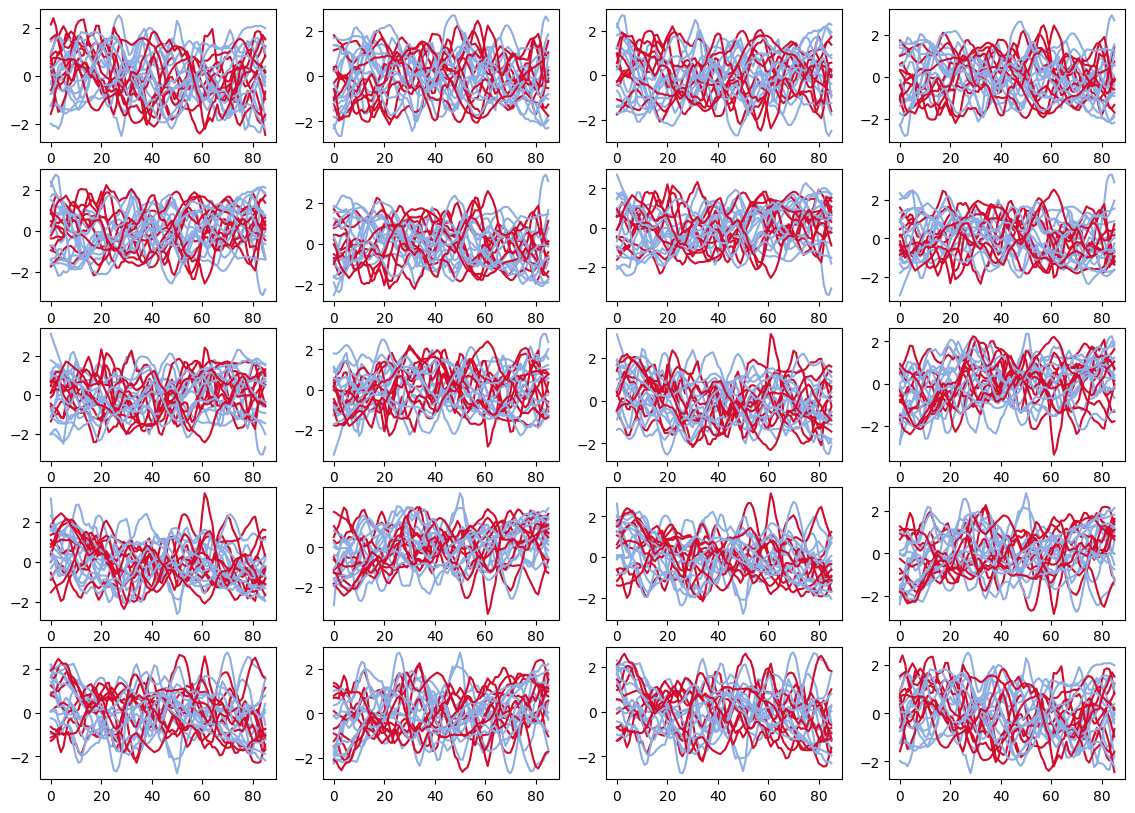

In [77]:
#per electrodes 1000Hz stimuli MMN plot of controls vs patients

# def mmn_comparison(stim):

fig,ax = plt.subplots(5,4,figsize=(14,10))
plt.ioff()

for r in range(5):
    for c in range(4):
        ec = (r*4)+c
        # print(r,c,ec)
        # ss=[]
        for s in mmn_eeg:
            # ss.append(s)
            pts=20
            if s not in null_data_checker.indices:
                if data[s]['category'] == 'Control':
                    x=mmn_eeg[s]['1000Hz'][ec,:]
                    x=(x-x.mean())/x.std()
                    ax[r,c].plot(x,'#8daee5',label='Control')
                else:
                    x=mmn_eeg[s]['1000Hz'][ec,:]
                    x=(x-x.mean())/x.std()
                    ax[r,c].plot(x,'#d30b2c',label='Patient')
        # print(ss)

# mmn_comparison('1000Hz')
fig

### Fuzzy Entropy Plots

#### per subject and region distribution

In [175]:
noControls=list()
noPatients=list()
for s in data:
    if s not in null_data_checker.indices:
        if data[s]['category']=='Control':
            noControls.append(s)
        elif data[s]['category']=='Patient':
            noPatients.append(s)

In [187]:
plt.ioff()
fig,ax = plt.subplots(len(noControls),5,figsize=(15,16))
fig.suptitle('Barcharts of Fuzzy Entropy per control subject on rows with gaussan noise spatial compensation')
sites = ['F','P','C','T','O']
for r,s in enumerate(noControls):
    for c,ent in enumerate([frontal_entropies,parietal_entropies,central_entropies,\
                            temporal_entropies,occipital_entropies]):
        plots.entropy_plot(ax[r,c],ent['rest1'][s],1)
        plots.entropy_plot(ax[r,c],ent['arith'][s],2)
        plots.entropy_plot(ax[r,c],ent['rest2'][s],3)
        plots.entropy_plot(ax[r,c],ent['auditory'][s],4)
        if c==0:
            ax[r,c].set_ylabel('Entropy['+s+']')
        else:
            ax[r,c].set_ylabel(' ')
        if r==len(noControls)-1:
            ax[r,c].set_xticks([1,2,3,4],['rest1','arith','rest2','auditory'])
        else:
            ax[r,c].set_xticks([],[])
            if r==0:
                ax[r,c].set_title(sites[c])
fig.tight_layout(pad=1.5)
plt.savefig('../data_analysis_results/FuzzEnt/Control/'+'all-fuzzyEntr.png',format='png')

In [188]:
plt.ioff()
fig,ax = plt.subplots(len(noPatients),5,figsize=(15,16))
fig.suptitle('Barcharts of Fuzzy Entropy per SZ(patient) subject on rows with gaussan noise spatial compensation')
sites = ['F','P','C','T','O']
for r,s in enumerate(noPatients):
    for c,ent in enumerate([frontal_entropies,parietal_entropies,central_entropies,\
                            temporal_entropies,occipital_entropies]):
        plots.entropy_plot(ax[r,c],ent['rest1'][s],1)
        plots.entropy_plot(ax[r,c],ent['arith'][s],2)
        plots.entropy_plot(ax[r,c],ent['rest2'][s],3)
        plots.entropy_plot(ax[r,c],ent['auditory'][s],4)
        if c==0:
            ax[r,c].set_ylabel('Entropy['+s+']')
        else:
            ax[r,c].set_ylabel(' ')
        if r==len(noPatients)-1:
            ax[r,c].set_xticks([1,2,3,4],['rest1','arith','rest2','auditory'])
        else:
            ax[r,c].set_xticks([],[])
            if r==0:
                ax[r,c].set_title(sites[c])
fig.tight_layout(pad=1.5)
plt.savefig('../data_analysis_results/FuzzEnt/Patient/'+'all-fuzzyEntr.png',format='png')

#### distribution plots

In [194]:
central_entropies

{'rest1': {'1': [inf, inf, inf, inf],
  '10': [inf, inf],
  '11': [inf, inf],
  '12': [inf, inf],
  '13': [inf, inf],
  '14': [inf, inf],
  '15': [inf, inf],
  '16': [],
  '17': [inf, inf],
  '18': [inf, inf],
  '19': [inf, inf],
  '2': [inf, inf, inf],
  '20': [inf, inf, inf],
  '21': [inf, inf],
  '22': [inf, inf, inf],
  '23': [inf, inf, inf],
  '24': [inf, inf],
  '25': [inf, inf],
  '26': [inf, inf],
  '27': [inf, inf],
  '28': [inf, inf, inf],
  '29': [inf, inf],
  '3': [inf, inf],
  '30': [inf, inf],
  '31': [inf, inf, inf],
  '32': [],
  '4': [inf, inf, inf],
  '5': [],
  '6': [inf, inf],
  '7': [inf, inf],
  '8': [],
  '9': []},
 'arith': {'1': [inf, inf, inf, inf],
  '10': [inf, inf],
  '11': [inf, inf],
  '12': [inf, inf],
  '13': [inf, inf],
  '14': [inf, inf],
  '15': [inf, inf],
  '16': [],
  '17': [inf, inf],
  '18': [inf, inf],
  '19': [inf, inf],
  '2': [inf, inf, inf],
  '20': [inf, inf, inf],
  '21': [inf, inf],
  '22': [inf, inf, inf],
  '23': [inf, inf],
  '24': [i

In [185]:
# functions
def all_region_entropies(region_entropies):
    control = {
        'rest1':np.empty(1),
        'arith':np.empty(1),
        'rest2':np.empty(1),
        'auditory':np.empty(1),
    }
    patient = copy.deepcopy(control)

    for s in noControls:
        for p in control.keys():
            control[p] = np.concatenate((control[p],region_entropies[p][s]),axis=0)
    
    for s in noPatients:
        for p in patient.keys():
            patient[p] = np.concatenate((patient[p],region_entropies[p][s]),axis=0)

    return control,patient

def region_entropies_kde(region_entropies,ax):
    control,patient=all_region_entropies(region_entropies)
    x=[
        control['rfrontalest1'],
        control['arith'],
        control['rest2'],
        control['auditory'],
        patient['rest1'],
        patient['arith'],
        patient['rest2'],
        patient['auditory'],
        ]
    x=pd.DataFrame(
        x,
        index=[
            'control_rest1',
            'control_arith',
            'control_rest2',
            'control_auditory',
            'patient_rest1',
            'patient_arith',
            'patient_rest2',
            'patient_auditory',
        ]
    ).T
    # x = x.fillna(0)
    # print(x)

    x.plot(kind='kde',subplots=[('control_rest1','patient_rest1'),\
                                ('control_arith','patient_arith'),\
                                    ('control_rest2','patient_rest2'),\
                                        ('control_auditory','patient_auditory')],\
                                            sharex=False,layout=(1,4),ax=ax)

/tmp/ipykernel_4205/636738411.py:49: UserWarning: When passing multiple axes, layout keyword is ignored.
  x.plot(kind='kde',subplots=[('control_rest1','patient_rest1'),\
/home/emmanuel/miniconda3/envs/neuroBCI/lib/python3.10/site-packages/numpy/core/function_base.py:157: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/emmanuel/miniconda3/envs/neuroBCI/lib/python3.10/site-packages/numpy/core/function_base.py:167: RuntimeWarning: invalid value encountered in add
  y += start
/home/emmanuel/miniconda3/envs/neuroBCI/lib/python3.10/site-packages/numpy/lib/function_base.py:2699: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]


ValueError: array must not contain infs or NaNs

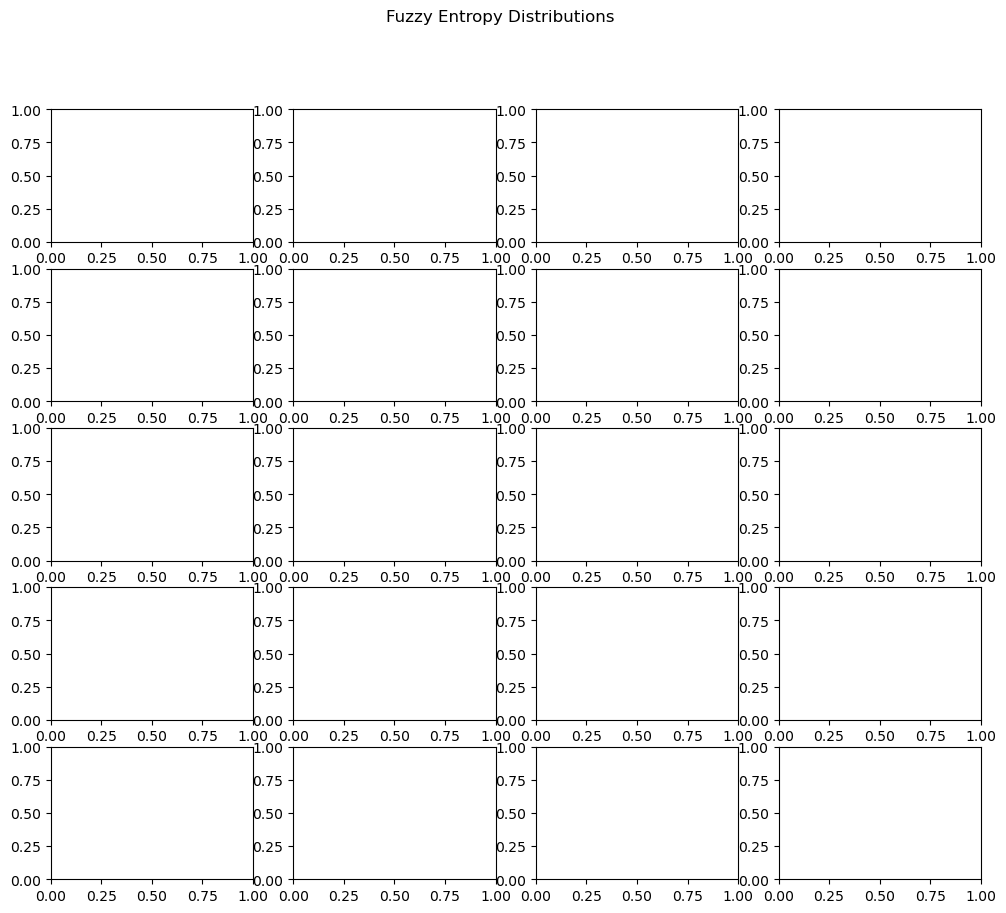

In [186]:
# plt.ioff()
fig,ax=plt.subplots(5,4,figsize=(12,10))
fig.suptitle('Fuzzy Entropy Distributions')
region_entropies_kde(frontal_entropies,ax[0,:])
region_entropies_kde(parietal_entropies,ax[1,:])
region_entropies_kde(central_entropies,ax[2,:])
region_entropies_kde(temporal_entropies,ax[3,:])
region_entropies_kde(occipital_entropies,ax[4,:])
fig.tight_layout()
for c in range(1,4):
    for r in range(5):
        ax[r,c].set_ylabel('')
for r in range(5):
    temp=['F','P','C','T','O']
    ax[r,0].set_ylabel(' Density'+'('+temp[r]+')')
del temp
# plt.savefig('../data_analysis_results/FuzzEnt/corticalRegions_DAQphase_distributions.png',format='png')

### Combine features per subject Class

In [ ]:
def fuzzyEntropySubjectCombiner(entropies):
    res_control = dict().fromkeys(entropies)
    res_patient = dict().fromkeys(entropies)
    for phase in entropies:
        mean_val_patient=0
        mean_val_control=0
        for i,s in enumerate(entropies[phase]):
            if s not in null_data_checker.indices:
                if data[s]['category']=='Control':
                    mean_val_control += np.array(entropies[phase][s]).mean()
                else:
                    mean_val_patient += np.array(entropies[phase][s]).mean()
        res_control[phase] = mean_val_control/12
        res_patient[phase] = mean_val_patient/10
    return res_control, res_patient

In [ ]:
frontalEntropies = fuzzyEntropySubjectCombiner(frontal_entropies)
parietalEntropies = fuzzyEntropySubjectCombiner(parietal_entropies)
temporalEntropies = fuzzyEntropySubjectCombiner(temporal_entropies)
centralEntropies = fuzzyEntropySubjectCombiner(central_entropies)
occipitalEntropies = fuzzyEntropySubjectCombiner(occipital_entropies)

Text(0.5, 1.0, 'Occipital Electrodes')

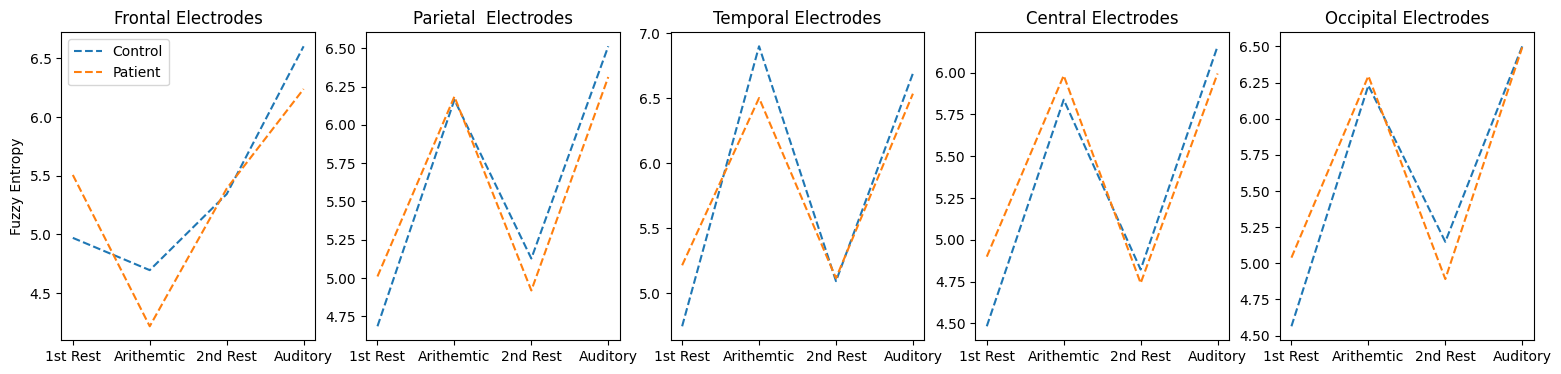

In [16]:

fig,ax = plt.subplots(1,5,figsize=(19,4))

for i,ent in enumerate([frontalEntropies,parietalEntropies,temporalEntropies,centralEntropies,occipitalEntropies]):
    y1=[ent[0][k] for k in ent[0]]
    y2=[ent[1][k] for k in ent[1]]
    ax[i].plot(y1,'--',label='Control')
    ax[i].plot(y2,'--',label='Patient')
    if i==0:
        ax[i].set_ylabel("Fuzzy Entropy")
        ax[i].legend()
    ax[i].set_xticks([0,1,2,3],['1st Rest', 'Arithemtic', '2nd Rest', 'Auditory'])
ax[0].set_title('Frontal Electrodes')
ax[1].set_title('Parietal  Electrodes')
ax[2].set_title('Temporal Electrodes')
ax[3].set_title('Central Electrodes')
ax[4].set_title('Occipital Electrodes')

In [89]:
def mmnCombine(mmn):
    res_control=dict().fromkeys([' ','1000Hz','3000Hz'])
    res_patient=dict().fromkeys([' ','1000Hz','3000Hz'])

    for i,s in enumerate(mmn):
        tdevControl,tdevPatient=np.empty((4,20)),np.empty((4,20))
        onekControl,onekPatient=np.empty((4,20)),np.empty((4,20))
        threekControl,threekPatient=np.empty((4,20)),np.empty((4,20))
        if s not in null_data_checker.indices:
            if data[s]['category']=='Control':
                tdevControl += mmn[s][' ']
                onekControl += mmn[s]['1000Hz']
                threekControl += mmn[s]['3000Hz']
            else:
                tdevPatient += mmn[s][' ']
                onekPatient += mmn[s]['1000Hz']
                threekPatient += mmn[s]['3000Hz']
    res_control[' ']=tdevControl/12
    res_control['1000Hz']=onekControl/12
    res_control['3000Hz']=threekControl/12
    res_patient[' ']=tdevPatient/10
    res_patient['1000Hz']=onekPatient/10
    res_patient['3000Hz']=threekPatient/10
    return res_control,res_patient

In [90]:
mmns = mmnCombine(avg_aud)

Text(0.5, 0, 'Time(s)')

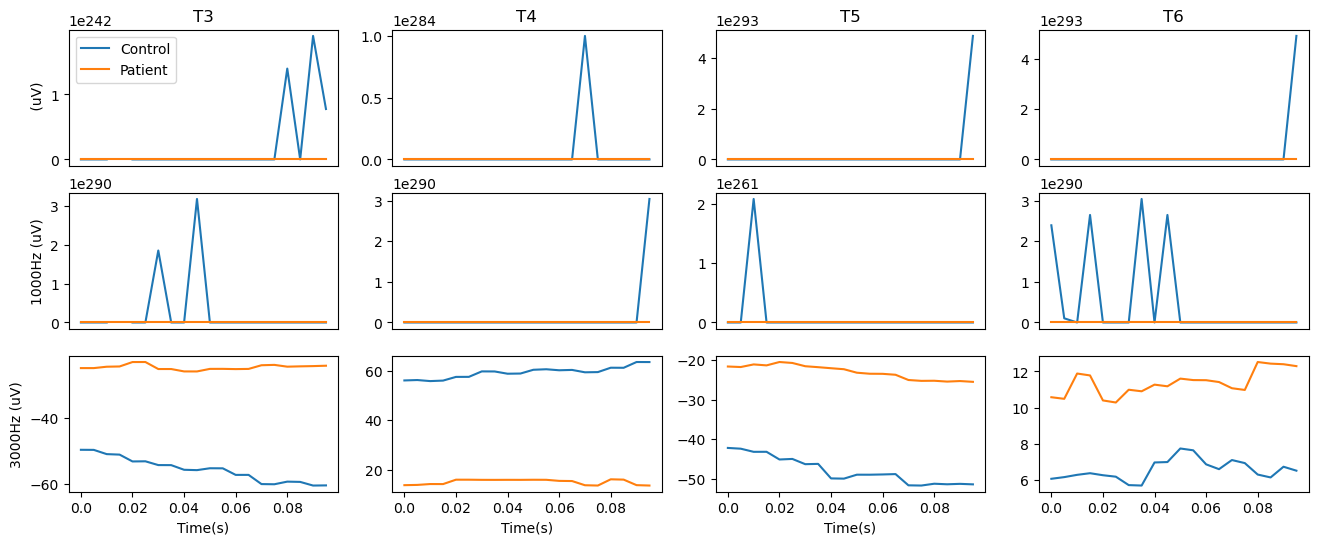

In [104]:
fig,ax = plt.subplots(3,4,figsize=(16,6))
xi=list(range(0,20,4))
x=(np.array(xi)/200).tolist()
ch=['T3','T4','T5','T6']
for r in range(3):
    ks=[' ','1000Hz','3000Hz']
    for c in range(4):
        ax[r,c].plot(mmns[0][ks[r]][c,:],label='Control')
        ax[r,c].plot(mmns[1][ks[r]][c,:],label='Patient')
        ax[r,c].set_xticks([],[])
ax[0,0].legend()
ax[0,0].set_title('T3')
ax[0,1].set_title('T4')
ax[0,2].set_title('T5')
ax[0,3].set_title('T6')
ax[2,0].set_xticks(xi,x)
ax[2,1].set_xticks(xi,x)
ax[2,2].set_xticks(xi,x)
ax[2,3].set_xticks(xi,x)
ax[0,0].set_ylabel(' (uV)')
ax[1,0].set_ylabel('1000Hz (uV)')
ax[2,0].set_ylabel('3000Hz (uV)')
ax[2,0].set_xlabel('Time(s)')
ax[2,1].set_xlabel('Time(s)')
ax[2,2].set_xlabel('Time(s)')